# Procesamiento de Imágenes - Trabajo Práctico N°4
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# Ejercicio 2

En este ejercicio se tiene como finalidad resaltar los vasos sanguíneos oculares de la imagen eyebw.jpg (incluida en la carpeta assets del proyecto) mediante la aplicación de transformaciones.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
# Add the folder path to the sys.path list
sys.path.append('../../src/helpers/')
from compare_images import compare_images
from plot_histogram import plot_histogram
from imadjust import imadjust

## Imagen a transformar

In [2]:
eyebw = np.array(Image.open('../../assets/ej2/eyebw.jpg'))  # Open

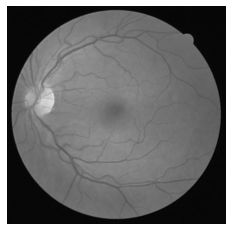

In [3]:
plt.axis('off')
plt.imshow(eyebw, cmap='gray')
plt.show()

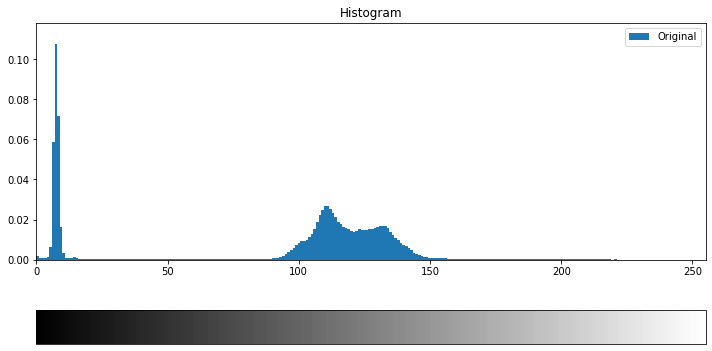

In [4]:
_, N, _ = plot_histogram(eyebw, title='Histogram')

## Transformaciones

Analizando el histograma se pueden encontrar dos sectores de interés. El primero de ellos es la región muy cercana a 0. Como primer análisis se supone que el pico presente en dicha región se debe a los bordes negros de la imagen. Sin embargo, para comprobarlo se filtra este rango de tal forma de observar si algunos vasos sanguíneos se ven afectados.

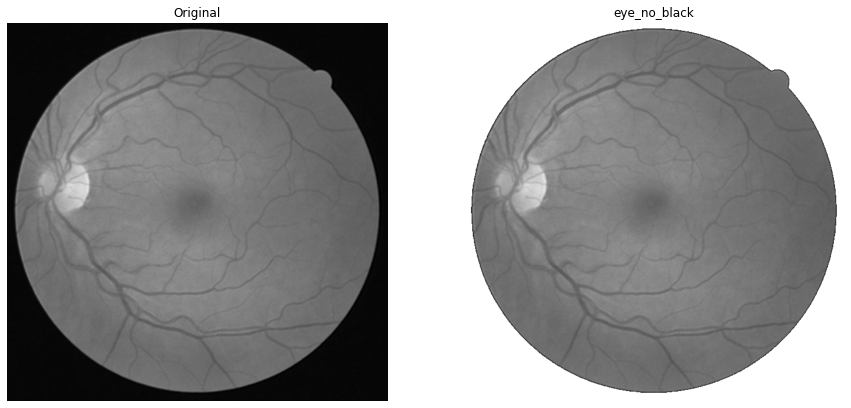

In [5]:
eye_no_black = eyebw.copy()
## Fondo
min_range = 0
max_range = 0.1*255

mask_transf = np.bitwise_and(min_range<=eye_no_black, eye_no_black<=max_range) 
eye_no_black[mask_transf] = 255
compare_images([eyebw, eye_no_black], ['Original','eye_no_black'])

Mediante la transformación anterior se comprobó que el rango de valores cercanos a 0 correspondían únicamente a los bordes negros de la imagen y no afectan al área de contenido.

Así, la región del histograma restante con contenido significativo es la región intermedia, aproximadamente entre 0,3 y 0,7 (valores normalizados). Dicha región corresponde a los grises, entre los que se encuentran tanto los vasos sanguíneos como el fondo de ellos. Por esta razón, en las siguientes etapas se busca resaltar a los grises de los vasos y hacer menos notorio el gris de fondo.

### Transformación lineal

Una transformación simple es convertir el rango de 0,3 a 0,7 al rango de 0 a 1, de tal forma que los grises se distribuyan en mayor medida a lo largo del histograma y que los valores de grises por fuera de este rango sean mapeados a blancos o negros absolutos.

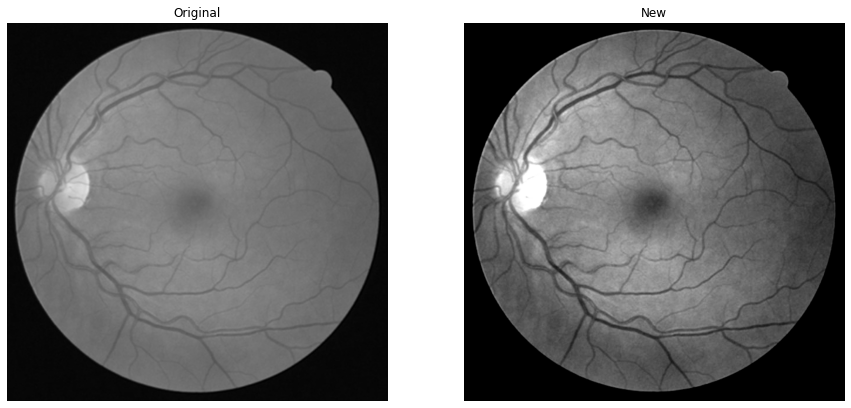

In [6]:
new = imadjust(eyebw, 0.3,0.7,0,1)
compare_images([eyebw, new], ['Original','New'])

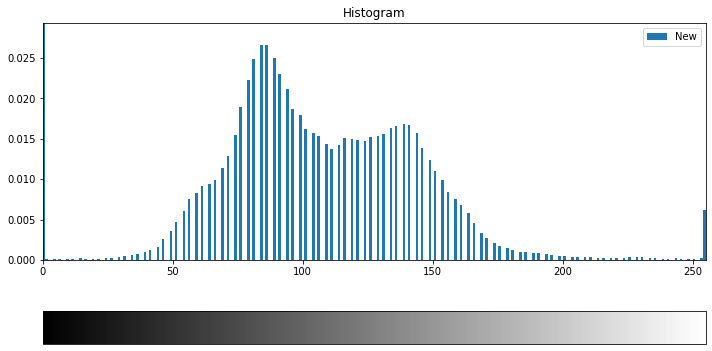

In [7]:
_ = plot_histogram(new, title='Histogram', label='New')

Luego de realizar la transformación, se distingue una gran mejora en la percepción de la mayor parte de los vasos sanguíneos. Al estirar la región más significativa del espectro, estos tomaron un valor más cercano a 0 (más oscuro), alejándose de los grises más claros como era el fondo. 


No obstante, si se contrasta la imagen original con la imagen generada, en la región izquierda de la imagen, donde existe una sección de color blanco (fondo del ojo), ciertos vasos sanguíneos, aunque eran poco apreciables, pasaron a ser totalmente imperceptibles. Si dicha región no fuera de interés, la imagen generada sería favorable. Igualmente, a continuación se aplican distintos procesamientos para intentar solventar el problema. La diferencia puede deberse a que los grises más claros fueron llevados en el histograma hacia valores aún más altos, acercándose a los blancos absolutos. A su vez, es posible que estos vasos presentaran partes pequeñas con valores mayores al 0,7, llevados entonces al valor de 1.  

Como una posible solución, se decidió realizar otra transformación lineal pero en este caso tomando como valor superior de entrada un número mayor. La transformación a aplicar es del rango 0,3 a 0,9 al rango de 0 a 1.


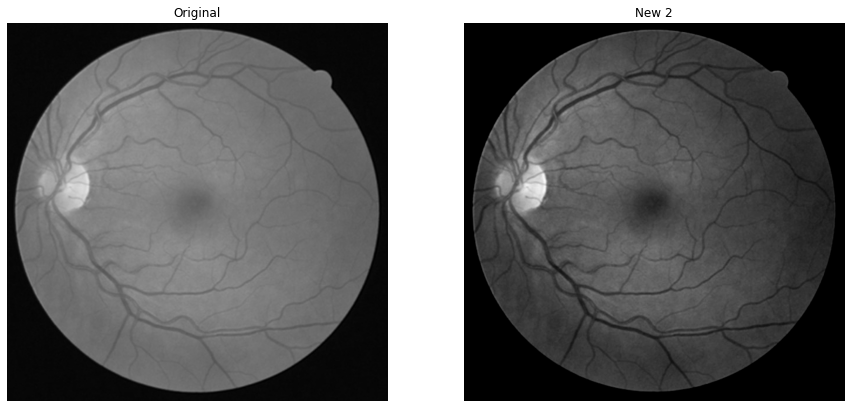

In [8]:
new2 = imadjust(eyebw, 0.3,0.9,0,1)
compare_images([eyebw, new2], ['Original','New 2'])

En este caso, los vasos sanguíneos son perceptibles, tanto en la región posterior del ojo (parte blanca) como en el resto de la imagen. Sin embargo, la imagen se tornó más oscura dado que solo el histograma se estiró en mayor medida hacia los valores oscuros. Este factor, si bien permite que se aprecien los vasos sanguíneos, no es ideal y sería preferible que el fondo fuera más claro.

Bajo este razonamiento, la transformación que se busca debe llevar los valores más bajos hacia valores más oscuros pero no transformar los valores claros en la misma escala. Así, una posible implementación es incorporar el parámetro $\gamma$ en la transformación, permitiendo que esta deje de ser lineal. 

![](../../assets/ej2/gamma-grey.png)

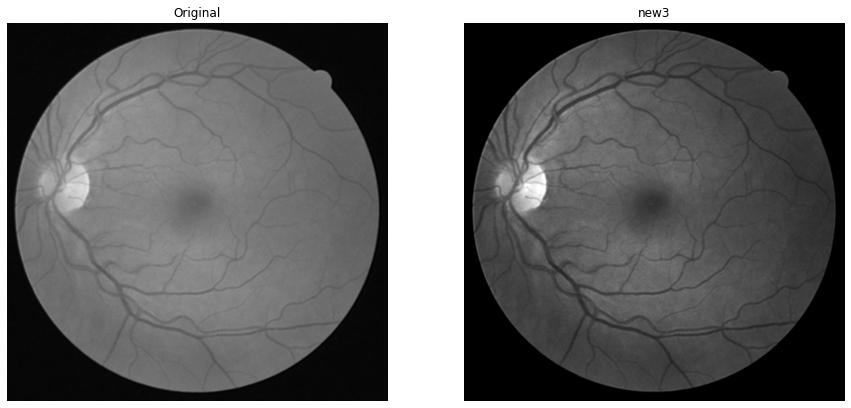

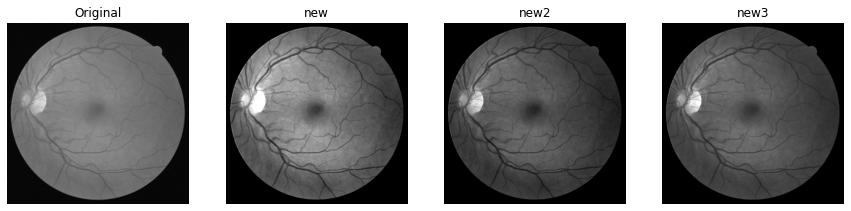

In [9]:
new3 = imadjust(eyebw, 0.15,0.85,0,1, gamma=1.5)
compare_images([eyebw, new3], ['Original','new3'])
compare_images([eyebw,new,new2, new3], ['Original','new','new2','new3'])

La imagen obtenida es algo más clara que la anterior debido a la incorporación del factor $\gamma$. Aún así, algunos sectores de ella podrían ser mejorados. Estos son apreciables en la sección derecha de la figura, donde los vasos sanguíneos no se encuentran totalmente destacados. Asimismo, en la sección central-izquierda sucede lo propio con los vasos más pequeños.

A modo de solucionar los problemas de estas secciones, se procede a reforzar o debilitar ciertos rangos de gris de tal forma que se genere un mayor contraste. Se comienza realizando lo propio para los vasos sanguíneos de la parte derecha.

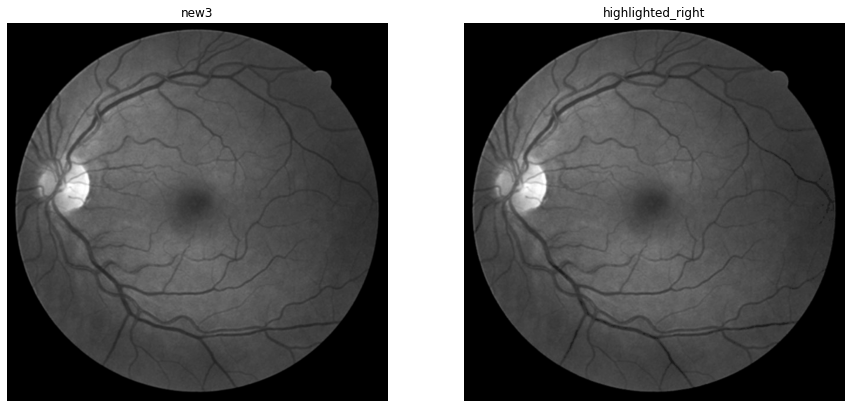

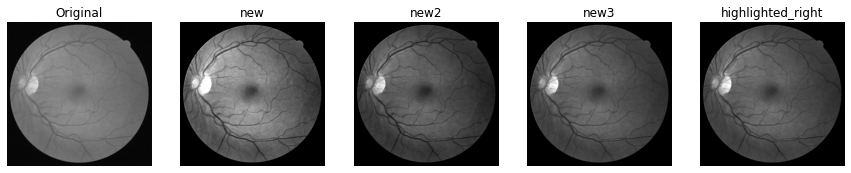

In [10]:
highlighted_right = eyebw.copy()

min_range = 70
max_range = 93

mask_transf = np.bitwise_and(min_range<=highlighted_right, highlighted_right<=max_range) 
highlighted_right[mask_transf] = highlighted_right[mask_transf]*0.9
highlighted_right = imadjust(highlighted_right, 0.15,0.85,0,1, gamma=1.5)

compare_images([new3, highlighted_right], ['new3','highlighted_right'])
compare_images([eyebw,new,new2, new3, highlighted_right], ['Original','new','new2','new3', 'highlighted_right'])

Tras debilitar el rango de grises utilizado se logró oscurecer algunos vasos sanguíneos, permitiendo que sean más apreciables. Sin embargo, al intentar repetir el procedimiento con otros rangos para oscurecer aún más vasos sanguíneos, algunas regiones del fondo también se oscurecían generando un resultado poco favorable.

A continuación, se refuerzan secciones de gris correspondientes al fondo de la parte central-izquierda de la imagen a fin de destacar los vasos de dicha región.

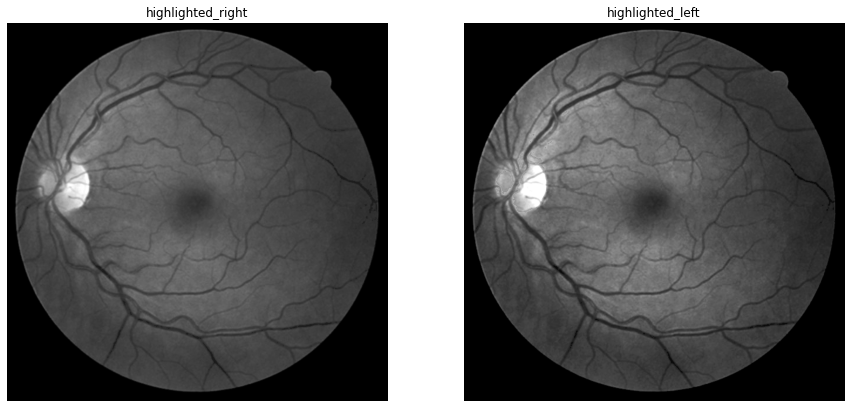

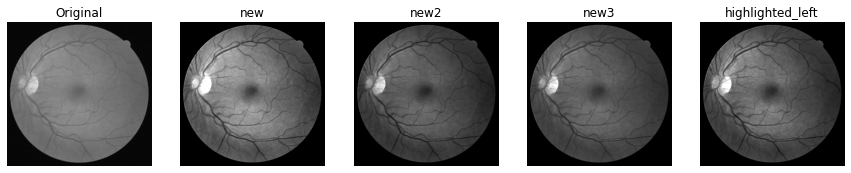

In [11]:
highlighted_left = eyebw.copy()
min_range = 70
max_range = 91

mask_transf = np.bitwise_and(min_range<=highlighted_left, highlighted_left<=max_range) 
highlighted_left[mask_transf] = highlighted_left[mask_transf]*0.9

min_range = 91
max_range = 160

mask_transf = np.bitwise_and(min_range<=highlighted_left, highlighted_left<=max_range) 
highlighted_left[mask_transf] = highlighted_left[mask_transf]*1.1

highlighted_left = imadjust(highlighted_left, 0.2,0.78,0,1, gamma=1.9)

compare_images([highlighted_right, highlighted_left], ['highlighted_right','highlighted_left'])
compare_images([eyebw,new,new2, new3, highlighted_left], ['Original','new','new2','new3', 'highlighted_left'])

In [12]:
final = highlighted_left.copy()

## Conclusión

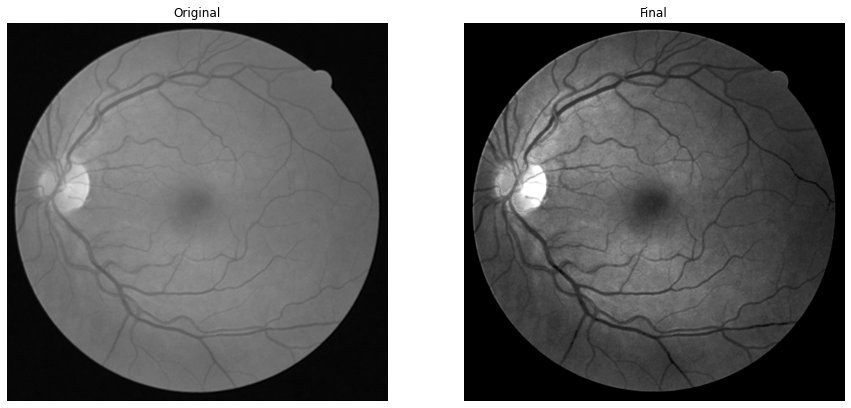

In [13]:

compare_images([eyebw, final], ['Original','Final'])

A modo de conclusión, a lo largo del ejercicio se realizaron distintas transformaciones que permitieron obtener una imagen donde los vasos sanguíneos se encuentran considerablemente más destacados que al compararlos con los de la imagen original. Para ello, se analizaron distintas transformaciones hasta llegar al resultado final que consta de una transformación que incluye al parámetro $\gamma = 1.9$ y a un refuerzo y debilitamiento de algunos rangos de gris. 

Analizando el resultado final, en la imagen se pueden observar adecuadamente tanto los vasos pequeños como los de mayor tamaño. Por otro lado, si bien los vasos sanguíneos son más notorios en algunas regiones, estos son correctamente apreciables en toda la imagen. 